In [1]:
%load_ext autoreload
%autoreload 2

%pylab notebook
%matplotlib inline
from pylab import *
from scipy.optimize import curve_fit

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['fft', 'power', 'random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [2]:
rcParams['figure.dpi'] = 100
rcParams['figure.facecolor'] = 'white'

In [3]:
import sys, numpy as np, scipy as sc, warnings, os, healpy as H
sys.path.append('../DRAFT/modules/')
import foregrounds as fg, misc, flatsky, misc, exp_specs

#import matplotlib.cbook
warnings.filterwarnings('ignore',category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)
#warnings.filterwarnings('ignore', category=OptimizeWarning)

In [4]:
#result_fname = 'results/splat_hitmask_galmask_galdustcl.npy'
result_fname = 'results/splat_hitmask_galmask_galdustcl_latsteps.npy'
freq = 145 #GHz
lmax = 512
which_spec = 'TT'
beam_val = 1.4 #S4-Wide beam - Note that the pySM sims have used S4-Wide beam and not the delensing LAT beam
bl = H.gauss_beam(np.radians(beam_val/60.), lmax = lmax-1)

In [5]:
#read results file
result_dict = np.load(result_fname, allow_pickle=True).item()
min_obs_el_arr = result_dict['hit_masks'].keys()
lat_masks_arr = result_dict['lat_masks'].keys()
dust_145ghz = result_dict['dust_145ghz']
print('Min. obs el arr = %s' %(min_obs_el_arr))
print('Last masks arr = %s' %(lat_masks_arr))

Min. obs el arr = dict_keys([20.0, 25.0, 30.0, 35.0, 40.0])
Last masks arr = dict_keys([(-90.0, -75.0), (-75.0, -60.0), (-60.0, -45.0), (-45.0, -30.0), (-30.0, -15.0), (-15.0, 0.0), (0.0, 15.0), (15.0, 30.0), (30.0, 45.0), (-90.0, 45.0)])


In [6]:
#galactic foreground in the original delensing LAT footprint
nside_tmp, lmax_tmp = 2048, 5000
param_dict = {}
param_dict['cl_gal_dic_dust_fname'] = 'results/cls_galactic_sims_dust_nside%s_lmax%s_delensing.npy' %(nside_tmp, lmax_tmp)
which_gal_mask = 0
el, cl_dust_fid = fg.get_cl_galactic(param_dict, 'dust', freq, freq, which_spec = which_spec, which_gal_mask = which_gal_mask, use_sed_scaling = True, use_power_law_fit = False)
el, cl_dust_fid = el[:lmax], cl_dust_fid[:lmax]
#deconvolve beam
cl_dust_fid = cl_dust_fid/bl**2.


# Show galactic dust spectrum as a fn(min_obs_el, lat_mask).
## Baseline SP-LAT is shown as the thick black line
### Test: only showing min_obs_el = 30 degrees


Analysing results for minimum observation elevation = 30 degrees


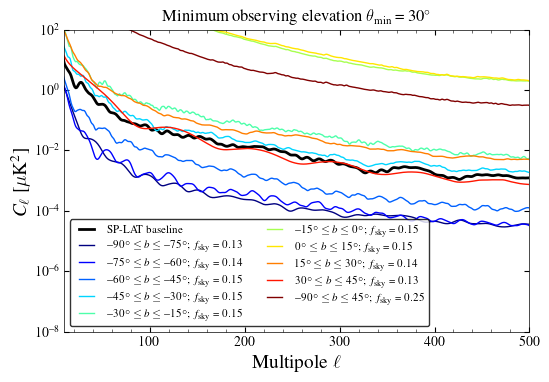

In [7]:
#now read the results file and show cl
reqd_min_obs_el = 30.
ell_norm = 80
xmin, xmax = 10, 500 #1000
ymin, ymax = 1e-8, 100.
for min_obs_el in min_obs_el_arr:

    #only showing min_obs_el = 30 degrees
    if min_obs_el != reqd_min_obs_el: continue

    print('\nAnalysing results for minimum observation elevation = %g degrees' %(min_obs_el))
    curr_hit_mask = result_dict['hit_masks'][min_obs_el]
    clf()
    ax=subplot(111, yscale = 'log')
    color_arr = [cm.jet(int(d)) for d in np.linspace(0, 255, len(lat_masks_arr))]
    plot(el, cl_dust_fid, color = 'black', lw = 2., label = r'SP-LAT baseline')
    
    for latcntr, (b1, b2) in enumerate( lat_masks_arr ):

        curr_lat_mask = result_dict['lat_masks'][(b1, b2)]
        curr_total_mask = curr_hit_mask * curr_lat_mask
        curr_fsky_val = len( np.where(curr_total_mask>0.)[0] )/len(curr_total_mask)
        
        
        cl_dust = result_dict['cl'][min_obs_el][(b1,b2)]
        cl_dust = cl_dust[:lmax]/bl**2.
        colorval = color_arr[latcntr]
        labval = r'$%g^{\circ} \le b \le %g^{\circ}$; $f_{\rm sky}=%.2f$' %(b1, b2, curr_fsky_val)
        plot(el, cl_dust, color = colorval, label = labval, lw = 1.); 
        #plot(el, cl_dust_fit, ls = '--', color = colorval, label = r'SPLAT-Baseline')
    xlim(xmin, xmax); ylim(ymin, ymax)
    xlabel(r'Multipole $\ell$', fontsize = 14)
    ylabel(r'$C_{\ell}\ [\mu {\rm K}^{2}]$', fontsize = 14)
    #axvline(ell_norm, ls = '-.');
    legend(loc = 3, fontsize = 8, ncol = 2)
    title(r'Minimum observing elevation $\theta_{\rm min} = %g^{\circ}$' %(min_obs_el))
    show(); 

# Baseline SP-LAT hit map (normalised) and Dust map @ 145 GHz from pySM

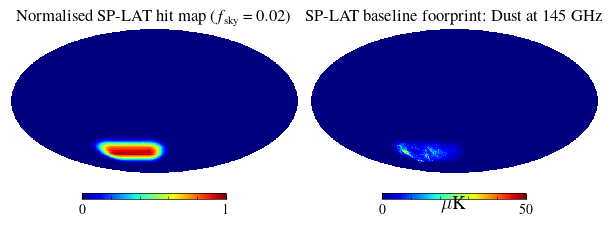

In [8]:
#calculate SP-LAT baseline again
minval, maxval = 0., 50.
dust_map = H.read_map('data/cmbs4_dust_uKCMB_LAT-MFL2_nside512_dust_0000.fits')
hit_map = H.read_map('data/cmbs4_hitmap_LAT-MFPL1_pole_nside512_1_of_1.fits')
hit_map = hit_map / np.max(hit_map)
#fsky=np.sum(hit_map[hit_map>0.]/len(hit_map))
#fsky=len( np.where(hit_map>0.3)[0] )/len(hit_map)
fsky=np.mean(hit_map)
H.mollview(hit_map, sub = (121), min = 0., max = 1., title = r'Normalised SP-LAT hit map ($f_{\rm sky} = %.2f$)' %(fsky));
H.mollview(dust_map * hit_map, sub = (122), unit = r'$\mu$K', min = minval, max = maxval, title = r'SP-LAT baseline foorprint: Dust at 145 GHz' %(fsky)); show()

# show all (hit/lat) masks

In [ ]:
minval, maxval = 0., 50.
for min_obs_el in min_obs_el_arr:
    #only showing min_obs_el = 30 degrees
    if min_obs_el != reqd_min_obs_el: continue

    print('\nAnalysing results for minimum observation elevation = %g degrees' %(min_obs_el))
    curr_hit_mask = result_dict['hit_masks'][min_obs_el]
    for (b1, b2) in lat_masks_arr:
        #print((b1, b2))
        curr_lat_mask = result_dict['lat_masks'][(b1, b2)]
        curr_total_mask = curr_lat_mask * curr_hit_mask
        curr_dust_map = np.copy( dust_145ghz ) * curr_total_mask
        curr_fsky_val = len( np.where(curr_total_mask>0.)[0] )/len(curr_total_mask)
        titleval = r'$\theta_{\rm min} = %g^{\circ}$; $%g^{\circ} \le b \le %g^{\circ}$; $f_{\rm sky}=%.2f$' %(min_obs_el, b1, b2, curr_fsky_val)
        clf()
        #figure(figsize=(6., 3.))
        suptitle(r'%s' %(titleval), x=0.25, y = 1.05, fontsize = 10)
        H.mollview(curr_total_mask, min = 0., max = 1., sub = (441), title = ''); 
        H.mollview(curr_dust_map, sub = (442), title = '', unit = r'$\mu$K', min = minval, max = maxval); 
        show(); 
        


Analysing results for minimum observation elevation = 30 degrees


In [ ]:
def power_law(ell, A, alpha, ell_norm = 80.):
    #print(A, alpha)#, end = ' ')
    fit = A * ((ell / ell_norm) ** alpha)
    badinds = np.where((fit == np.inf) | (fit == np.nan))[0]
    fit[badinds]=0.
    return fit
def perform_fit(el, cl, ell_norm = 80):
    dl_fac = (el * (el + 1))/2/np.pi
    dl = cl * dl_fac
    badinds = np.where((dl == np.inf) | (dl == np.nan))[0]
    dl[badinds]=0.
    amp_ini = dl[el == ell_norm][0]
    if which_spec == 'EE':
        alpha_ini = -.4
    elif which_spec == 'TT':
        alpha_ini = -.3
    #print(amp_ini*0.1, amp_ini*3., alpha_ini-0.2, alpha_ini+0.2); sys.exit()
    delta_alpha = 0.1
    amp_low_fac, amp_high_fac = 0.95, 1.05 #0.1, 3.
    pars, cov = curve_fit(f=power_law, xdata=el, ydata=dl, p0=[amp_ini, alpha_ini], bounds = ((amp_ini*amp_low_fac, alpha_ini-delta_alpha), (amp_ini*amp_high_fac, alpha_ini+delta_alpha)))
    dl_fit = power_law(el, pars[0], pars[1])
    cl_fit = dl_fit / dl_fac

    return cl_fit, pars

In [ ]:
if (0):
    hmask1 = result_dict['lat_masks'][(-90.0, -75.0)]
    fsky1 = len( np.where(hmask1>0.)[0] )/len(hmask1)
    hmask2 = result_dict['lat_masks'][(-90.0, 0.0)]
    fsky2 = len( np.where(hmask2>0.)[0] )/len(hmask2)
    H.orthview(hmask1, title = r'$f_{\rm sky}$ = %.2f' %(fsky1)); show()
    H.orthview(hmask2, title = r'$f_{\rm sky}$ = %.2f' %(fsky2)); show()